This script tests the weight optimization procedure of ColRel using gradient descent based optimization algorithms

In [1]:
# Requirements

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)

torch.manual_seed(0)

In [2]:
# mmWave network topology definition

def client_locations_mmWave_clusters_intermittent(num_clients: int = 10):
    """
    :param num_clients: Number of federated edge learning clients
    :return: probability of successful transmission to PS, and inter-client connectivity matrix
    """

    # PS is placed at origin
    PS_loc = np.array([0, 0])

    # Distance of good clients from PS
    circle_good_rad = 159                       # meters. For prob success ~ 0.9

    # Clients angles
    client_vec_deg = np.zeros(num_clients)
    client_vec_deg[3] = 2 * np.pi / 3
    client_vec_deg[6] = 4 * np.pi / 3

    x = np.zeros(num_clients)
    y = np.zeros(num_clients)

    # Determining the Cartesian coordinates of the clients with good connectivity
    x[0] = circle_good_rad * np.cos(client_vec_deg[0])
    y[0] = circle_good_rad * np.sin(client_vec_deg[0])
    x[3] = circle_good_rad * np.cos(client_vec_deg[3])
    y[3] = circle_good_rad * np.sin(client_vec_deg[3])
    x[6] = circle_good_rad * np.cos(client_vec_deg[6])
    y[6] = circle_good_rad * np.sin(client_vec_deg[6])

    d = 159                       # Distance of bad clients in each cluster to the good client of the cluster

    # Cluster 1
    ang1 = 1.582
    x[1] = x[0] + d * np.cos(ang1)
    y[1] = y[0] + d * np.sin(ang1)
    print("Distance = {}".format(np.sqrt(x[1] ** 2 + y[1] ** 2)))

    ang2 = - 1.582
    x[2] = x[0] + d * np.cos(ang2)
    y[2] = y[0] + d * np.sin(ang2)

    # Cluster 2
    ang4 = 2 * np.pi / 3 + 1.582
    x[4] = x[3] + d * np.cos(ang4)
    y[4] = y[3] + d * np.sin(ang4)

    ang5 = 2 * np.pi / 3 - 1.582
    x[5] = x[3] + d * np.cos(ang5)
    y[5] = y[3] + d * np.sin(ang5)

    # Cluster 3
    ang7 = 4 * np.pi / 3 - 1.582
    x[7] = x[6] + d * np.cos(ang7)
    y[7] = y[6] + d * np.sin(ang7)

    ang8 = 4 * np.pi / 3 - 1.54
    x[8] = x[6] + d * np.cos(ang8)
    y[8] = y[6] + d * np.sin(ang8)

    ang9 = 4 * np.pi / 3 + 1.582
    x[9] = x[6] + d * np.cos(ang9)
    y[9] = y[6] + d * np.sin(ang9)

    # Client locations
    loc_clients = []
    for idx in range(num_clients):
        loc_clients.append([x[idx], y[idx]])
    loc_clients = np.array(loc_clients)

    # Compute distances of clients from PS
    sub_clients_PS = loc_clients - PS_loc
    dist_clients_PS2 = np.zeros(len(sub_clients_PS))
    for idx in range(len(sub_clients_PS)):
        dist_clients_PS2[idx] = sub_clients_PS[idx][0] ** 2 + sub_clients_PS[idx][1] ** 2
    dist_clients_PS = np.sqrt(dist_clients_PS2)

    # Compute pairwise distances between clients
    dist_clients_clients = np.zeros([num_clients, num_clients])
    for i in range(len(loc_clients)):
        for j in range(len(loc_clients)):
            dist_vector = loc_clients[i] - loc_clients[j]
            dist_clients_clients[i][j] = np.linalg.norm(dist_vector, 2)

    # Compute probability of successful transmission to PS
    prob_success_PS = np.zeros(num_clients)
    for i in range(len(dist_clients_PS)):
        p = min(1, np.exp(-dist_clients_PS[i] / 30 + 5.2))
        prob_success_PS[i] = np.round(p * 100) / 100

    # Determine connectivity amongst clients
    P = np.zeros([num_clients, num_clients])
    connectivity_mat_clients = np.zeros([num_clients, num_clients])
    for i in range(num_clients):
        for j in range(num_clients):
            p = min(1, np.exp(-dist_clients_clients[i][j] / 30 + 5.2))
            if p > 0.5:
                P[i][j] = p
                connectivity_mat_clients[i][j] = 1

    with open('prob_success_PS.npy', 'wb') as f:
        np.save(f, prob_success_PS)
    with open('connectivity_mat_clients.npy', 'wb') as f:
        np.save(f, connectivity_mat_clients)

    return prob_success_PS, P, connectivity_mat_clients

In [3]:
# Topology induce variance

def evaluate_tiv(p: torch.Tensor = None, A: torch.Tensor = None, P: torch.Tensor = None):
    """Evaluate the upper bound on topology induced variance
        :param p: Array of transmission probabilities from each of the clients to the PS.
        :param A: Matrix of weights
        :param P: Matrix of probabilities for intermittent connectivity amongst clients
    """
    
    num_clients = len(p)
    A_dim = A.shape
    neighbors_dim = P.shape
    
    # Validate inputs
    assert num_clients == A_dim[0] == A_dim[1]
    assert num_clients == neighbors_dim[0] == neighbors_dim[1]
    
    # First term
    S = 0

    # First term
    for i in range(num_clients):
        for l in range(num_clients):
            for j in range(num_clients):
                S += p[j] * (1 - p[j]) * P[i][j] * P[l][j] * A[i][j] * A[l][j]

    # Second term
    for i in range(num_clients):
        for j in range(num_clients):
            S += P[i][j] * p[j] * (1 - P[i][j]) * A[i][j] * A[i][j]

    # Third term
    for i in range(num_clients):
        for l in range(num_clients):
            assert P[i][l] == P[l][i], "Matrix P must be symmetric."
            E = P[i][l]
            S += p[i] * p[l] * (E - P[i][l] * P[l][i]) * A[l][i] * A[i][l]
            
    # Compute the bias terms
    s = torch.zeros(num_clients)
    for i in range(num_clients):
        for j in range(num_clients):
            s[i] += p[j] * P[i][j] * A[i][j]
            
    # Contribution of the term due to bias
    for i in range(num_clients):
        for j in range(num_clients):
            S += (s[i]*s[j] - 2*s[i] + 1)

    return S


In [4]:
# Regularization to control bias

def evaluate_regularizer(p: torch.Tensor = None, A: torch.Tensor = None, P: torch.Tensor = None, 
                         reg_type: str = "L2", reg_strength: torch.Tensor = torch.tensor(0)):
    """Evaluate the regularization term
        :param p: Array of transmission probabilities from each of the clients to the PS.
        :param A: Matrix of weights
        :param P: Matrix of probabilities for intermittent connectivity amongst clients
        :param reg_type: Type of regularization
        :param reg_strength: Hyperparameter -- weight of regularization term
    """
    
    num_clients = len(p)
    A_dim = A.shape
    neighbors_dim = P.shape
    
    # Validate inputs
    assert num_clients == A_dim[0] == A_dim[1]
    assert num_clients == neighbors_dim[0] == neighbors_dim[1]
    
    if reg_type == "L2":
        
        # Compute the bias terms
        bias = torch.zeros(num_clients)
        for i in range(num_clients):
            for j in range(num_clients):
                bias[i] += p[j] * P[i][j] * A[i][j]
            bias[i] -= 1
            
        return reg_strength / 2.0 * torch.norm(bias, 2) ** 2 
    
    elif reg_type == "L1":
        
        # Compute the bias terms
        bias = torch.zeros(num_clients)
        for i in range(num_clients):
            for j in range(num_clients):
                bias[i] += p[j] * P[i][j] * A[i][j]
            bias[i] -= 1
            
        return reg_strength / 2.0 * torch.norm(bias, 1) ** 2
    

In [5]:
# Torch optimization object

class Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self, p: torch.Tensor = None, P: torch.Tensor = None, 
                 reg_type: str = "L2", reg_strength: torch.Tensor = torch.tensor(0)):
        
        super().__init__()
        num_clients = len(p)
        
        # Initialize weights with random numbers
        weights = torch.distributions.Uniform(0, 0.1).sample((num_clients, num_clients))

        # Initial weights are consistent with network topology
        weights = torch.where(P > 0, weights, 0)
        
        # Make weights torch parameters
        self.weights = nn.Parameter(weights)        
        
    def forward(self, p, P, reg_type: str = "L2", reg_strength: torch.Tensor = torch.tensor(0)):
        """Implement the topology induced variance to be optimized
        """
        
        A = self.weights
        return evaluate_tiv(p, A, P) + evaluate_regularizer(p, A, P, reg_type, reg_strength)

In [6]:
# Clipping to ensure non-negative weights

class ZeroClipper(object):
    """Clip the weights to zero if they are negative
    """

    def __init__(self, frequency=1):
        self.frequency = frequency

    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'weights'):
            w = module.weights.data
            nn.ReLU(inplace=True)(w)

In [7]:
# Optimization loop

clipper = ZeroClipper()

def training_loop(model: nn.Module, optimizer, n: int = 3000):
    "Training loop for torch model."
    losses = []
    
    for i in range(n):
        
        loss = model(p, P, reg_type, reg_strength)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if i % clipper.frequency == 0:
            model.apply(clipper)
            
        losses.append(loss) 
        
        if i % 100 == 0:
            print(f"Iteration: {i}/{n}")
        
    return losses

In [8]:
# Instantiate model and network topology
num_clients = 5
p = torch.Tensor([0.5, 0.4, 0.3, 0.8, 0.9])
P = 0.2 * torch.ones(num_clients, num_clients)
P.fill_diagonal_(1)
reg_type = "L1"
reg_strength = torch.tensor(5)

# num_clients = 10
# p, P, _ = client_locations_mmWave_clusters_intermittent(num_clients)
# print(f"p = {p}")
# print(f"P = \n{P}")
# p = torch.tensor(p)
# P = torch.tensor(P)
# reg_type = "L1"
# reg_strength = torch.tensor(0)

Iteration: 0/3000
Iteration: 100/3000
Iteration: 200/3000
Iteration: 300/3000
Iteration: 400/3000
Iteration: 500/3000
Iteration: 600/3000
Iteration: 700/3000
Iteration: 800/3000
Iteration: 900/3000
Iteration: 1000/3000
Iteration: 1100/3000
Iteration: 1200/3000
Iteration: 1300/3000
Iteration: 1400/3000
Iteration: 1500/3000
Iteration: 1600/3000
Iteration: 1700/3000
Iteration: 1800/3000
Iteration: 1900/3000
Iteration: 2000/3000
Iteration: 2100/3000
Iteration: 2200/3000
Iteration: 2300/3000
Iteration: 2400/3000
Iteration: 2500/3000
Iteration: 2600/3000
Iteration: 2700/3000
Iteration: 2800/3000
Iteration: 2900/3000
Parameter containing:
tensor([[1.1604, 0.6701, 0.5909, 0.9110, 0.9999],
        [0.7464, 1.1051, 0.6757, 0.9543, 1.0396],
        [0.7608, 0.7042, 1.0198, 0.9524, 1.0346],
        [0.3471, 0.2978, 0.2750, 1.0111, 0.6447],
        [0.2165, 0.1714, 0.1098, 0.4740, 0.9802]], requires_grad=True)


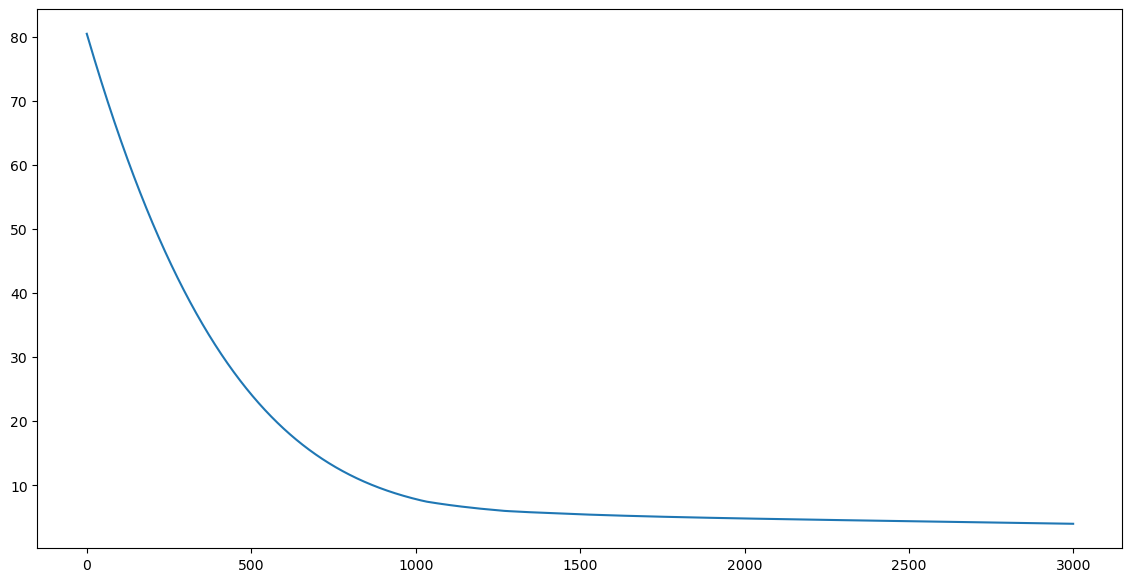

In [9]:
# Do the optimization

m = Model(p, P, reg_type, reg_strength)
# Instantiate optimizer
opt = torch.optim.Adam(m.parameters(), lr=0.001)
losses = training_loop(m, opt)
plt.figure(figsize=(14, 7))
with torch.no_grad():
    plt.plot(losses)

print(m.weights)

In [10]:
print(f"Final loss: {losses[-1]}")

Final loss: 4.011569023132324


In [11]:
W = m.weights.detach().numpy()

In [12]:
print(evaluate_tiv(p, W, P))

tensor(3.7368)


In [13]:
print("Check biasedness for each node: \n")

bias = torch.zeros(num_clients)
for i in range(num_clients):
    for j in range(num_clients):
        bias[i] += p[j] * P[i][j] * W[i][j]
    bias[i] -= 1
    print(f"Bias at node {i} is {bias[i]}")

Check biasedness for each node: 

Bias at node 0 is -0.0050008296966552734
Bias at node 1 is -0.10295987129211426
Bias at node 2 is -0.22302687168121338
Bias at node 3 is -3.325939178466797e-05
Bias at node 4 is 2.562999725341797e-05
